<h1 style="color: lightblue; text-align: center; font-weight: bold">非线性规划与模拟退火</h1>

主要参考:

[scipy.optimize.minimize — SciPy v1.8.1 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

[Optimization (scipy.optimize) — SciPy v1.8.1 Manual](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)

[Disciplined Convex Programming — CVXPY 1.2 documentation](https://www.cvxpy.org/tutorial/dcp/index.html)

[Advanced Features — CVXPY 1.2 documentation](https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver)


<br><br>

## 非线性规划

### 一般形式

$$
\begin{aligned}
&\min \quad f(x),\\
&s.t. \quad
\begin{cases}
g_i(x) \leq 0, i = 1, 2, \cdots, m,\\
h_j(x) = 0, j = 1, 2, \cdots, l.
\end{cases}
\end{aligned}
$$

---

### $\bigstar$使用scipy.optimize求解

例1【书上例6.4，P206】
$$
\begin{aligned}
&\min \quad \frac{2+x_1}{1+x_2}-3x_1+4x_3,\\
&s.t. \quad
0.1\leq x_i\leq 0.9,\quad i=1,2,3
\end{aligned}
$$

In [5]:
import numpy as np
from scipy import optimize

def obj(x): # 目标函数
    x1, x2, x3 = x
    return (2+x1)/(1+x2) - 3*x1 + 4*x3

bnds = list(zip([0.1]*3, [0.9]*3)) # 生成bounds约束的几种写法
# bnds = np.tile([0.1, 0.9], (3, 1))
# bnds = np.array([0.1, 0.9]*3).reshape((3, 2))

res = optimize.minimize(obj, np.ones(3), bounds=bnds) # 第2个参数为初值
# 这里用到method='L-BFGS-B'
res

      fun: -0.7736842105263159
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.47368422, -0.80332409,  4.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.9, 0.9, 0.1])


<h2 style="color: pink; text-align: center; font-weight: bold">optimize.minimize()方法</h2>

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207231355830.png)

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207221543903.png)

- method: str or callable, optional; If not given, chosen to be one of 'BFGS', 'L-BFGS-B', 'SLSQP', depending on whether or not the problem has constraints or bounds.

- bounds: 写成list, tuple, ndarray都可以,每项(min, max)表示各个变量的范围,None表示无界

- constraints: {Constraint, dict} or List of {Constraint, dict}

- 如果能计算jacobi矩阵,hessian矩阵,可以写上去提高精度. 在constraints里面也可以加上jacobi 

<br>


constraints的标准格式:

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207231404699.png)

注意: 'ineq'所对应的表达式是**非负的**$\geq 0$

<br>
 

例2 【书上例6.5，P206】
$$
\begin{aligned}
&\max \quad z = x_1^2 + x_2^2 +3x_3^2+4x_4^2+2x_5^2-8x_1-2x_2-3x_3-x_4-2x_5,\\
&s.t. \quad
\begin{cases}
x_1 + x_2 + x_3+x_4+x_5 \leq 400,\\
x_1 + 2x_2 + 2x_3+x_4+6x_5 \leq 800,\\
2x_1 +x_2 +6x_3 \leq 200,\\
x_3 + x_4 +5x_5\leq 200,\\
0 \leq x_i \leq 99,\quad i=1,2,\cdots,5.
\end{cases}
\end{aligned}
$$

In [6]:
import numpy as np
from scipy import optimize

def obj(x):
    c1 = np.array([1, 1, 3, 4, 2])
    c2 = np.array([-8, -2, -3, -1, -2])
    return -(c1 @ x**2 + c2 @ x) # 记得加负号
def g1(x):
    return b - A @ x # 非负


A = np.array([[1, 1, 1, 1, 1],
              [1, 2, 2, 1, 6],
              [2, 1, 6, 0, 0],
              [0, 0, 1, 1, 5]])
b = np.array([400, 800, 200, 200])
bnds = np.tile([0, 99], (5, 1))
cons = {'type': 'ineq',
        'fun': g1} # 保证'fun'>=0
res = optimize.minimize(obj, np.ones(5)*(1000), constraints=cons, bounds=bnds) 
# 只能求出局部极值，要多尝试几个初值
# 事实上这不是一个凸规划，局部最优解不等于全局最优解
# 这里用到method='SLSQP'
res.fun *= -1
res

     fun: 51629.92999503741
     jac: array([ -93.        , -196.        ,    3.        , -791.        ,
        -78.79980469])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([5.05000000e+01, 9.90000000e+01, 1.85343542e-09, 9.90000000e+01,
       2.02000000e+01])

<h2 style="color: pink; text-align: center; font-weight: bold">optimize中的全局优化方法</h2>


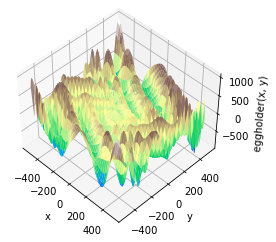

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1] + 47))))
            - x[0] * np.sin(np.sqrt(abs(x[0] - (x[1] + 47)))))


bounds = [(-512, 512), (-512, 512)]

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid]) # 直接在axis=0堆起来，xy[0]=x,xy[1]=y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()


In [115]:
results = dict()
results['brute'] = optimize.brute(eggholder, bounds, Ns=20, full_output=True)
results['shgo'] = optimize.shgo(eggholder, bounds)
results['DA'] = optimize.dual_annealing(eggholder, bounds)
results['DE'] = optimize.differential_evolution(eggholder, bounds)
results['BH'] = optimize.basinhopping(eggholder, bounds)
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5,sampling_method='sobol')

# results['brute'] # 暴力算法
# results['shgo'] # 单纯同调全局优化
# results['DA'] # 模拟退火
# results['DE'] # 差分进化
# results['BH'] # 盆地跳跃
# results['shgo_sobol'] # 可以返回计算出的局部极小值

---

### $\bigstar$使用cvxpy求解

例3【书上例6.7，P208】
$$
\begin{aligned}
&\min \quad z = x_1^2 + x_2^2 +3x_3^2+4x_4^2+2x_5^2-8x_1-2x_2-3x_3-x_4-2x_5,\\
&s.t. \quad
\begin{cases}
0\leq x_i\leq 99,\quad 且x_i为整数（i=1,\cdots ,5),\\
x_1 + x_2+x_3+x_4+x_5\leq 400,\\
x_1 + 2x_2 +2x_3+x_4+6x_5\leq 800,\\
2x_1+x_2 +6x_3 \leq 200,\\
x_3 + x_4 +5x_5\leq 200,
\end{cases}
\end{aligned}
$$

In [25]:
import numpy as np
import cvxpy as cp 

c1 = np.array([1, 1, 3, 4, 2])
c2 = np.array([-8, -2, -3, -1, -2])
A = np.array([[1, 1, 1, 1, 1],
              [1, 2, 2, 1, 6],
              [2, 1, 6, 0, 0],
              [0, 0, 1, 1, 5]])
b = np.array([400, 800, 200, 200])


x = cp.Variable(5, integer=True)
z = cp.Variable(pos=True)
cons = [A @ x <= b, 0 <= x, x <= 99, z >= c1 @ x**2 + c2 @ x]
# obj = cp.Minimize(c1 @ x**2 + c2 @ x) # pyscipopt的接口要求目标函数中不能包含非线性项
obj = cp.Minimize(z) # pyscipopt的接口要求目标函数中不能包含非线性项
                                        
# x = cp.Variable(3, integer=True) # 更改题目: 如果x只有3个变量是整数呢? 
# y = cp.Variable(2)
# obj = cp.Minimize(c1 @ cp.hstack((x,y))**2 + c2 @ cp.hstack((x,y)))
# cons = [A @ cp.hstack((x,y)) <= b, 0 <= cp.hstack((x,y)), cp.hstack((x,y)) <= 99]


prob = cp.Problem(obj, cons)
# prob.solve()
# prob.solve(solver='GLPK_MI') # 无法求解
prob.solve(solver='ECOS_BB') # 解可能有错
# prob.solve(solver='SCIP') # 注意格式（pyscipopt的接口要求目标函数中不能包含非线性项）

print(prob.value, x.value, sep='\n')

0.0
[3. 1. 1. 1. 1.]


In [31]:
# DEBUG: 似乎用scip也不能
import numpy as np
import cvxpy as cp

x = cp.Variable(integer=True)
y = cp.Variable(integer=True)
# z = cp.Variable(integer=True)
cons = [0 <= x, x <= 5, 0 <= y, y <= 5, 2*x+y <= 8]
obj = cp.Maximize(cp.abs(x) * cp.abs(y))
prob = cp.Problem(obj, cons)
# prob.solve(solver='SCIP')
prob.solve(solver='SCIP')

print(prob.value, x.value, sep='\n')

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
abs(var1417) @ abs(var1418)

In [36]:
from pyscipopt import Model

md = Model()
x = md.addVar('x', lb=0, ub=5, vtype='I')
y = md.addVar('y', lb=0, ub=5, vtype='I')
z = md.addVar('z')
md.setObjective(z, sense='maximize')
md.addCons(2*x + y <= 8)
md.addCons(x * y == z)

md.optimize()
sol = md.getBestSol()
print(sol[x], sol[y], sol[z], sep='\n')

2.0
4.0
8.0


In [ ]:
cp.installed_solvers() # 查看已安装的求解器类型

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS']

<h2 style="color: pink; text-align: center; font-weight: bold">使用cvxpy的注意事项与求解器</h2>

- 整数规划 & 混合整数规划

The preferred open source mixed-integer solvers in CVXPY are GLPK_MI, CBC and SCIP. 

SCIP supports nonlinear models, but **GLPK_MI** and CBC do not.

CVXPY comes with **ECOS_BB** – an open source mixed-integer nonlinear solver – by default. However ECOS_BB will not be called automatically; you must explicitly call prob.solve(solver='ECOS_BB') if you want to use it (changed in CVXPY 1.1.6). This policy stems from the fact that there are recurring correctness issues with ECOS_BB. If you rely on this solver for some application then you need to be aware of the increased risks that come with using it. If you need to use an open-source mixed-integer nonlinear solver from CVXPY, then we recommend you install SCIP.

- 默认求解器

By default CVXPY calls the solver most specialized to the problem type. For example, **ECOS** is called for SOCPs. **SCS** can handle all problems (except mixed-integer programs). If the problem is a QP, CVXPY will use **OSQP**.

LP线性规划 QP二次规划 SOCP二阶锥规划 SDP半正定规划 EXP POW MIP混合整数规划

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207230228877.png)

例4【补充例题】

$$
\begin{aligned}
&\min \quad z = 0.5x_1^2 + x_2^2 -x_1x_2-2x_1-6x_2,\\
&s.t. \quad
\begin{cases}
x_1+x_2 \leq 2,\\
-x_1+2x_2\leq 2,\\
2x_1+x_2\leq 3,\\
x_1 \geq 0.
\end{cases}
\end{aligned}
$$

In [118]:
import numpy as np
import cvxpy as cp

H = np.array([[0.5, -0.5],
              [-0.5, 1]]) # 正定
g = np.array([-2, -6])
A = np.array([[1, 1],
              [-1, 2],
              [2, 1]])
b = np.array([2, 2, 3])

x = cp.Variable(2)
obj = cp.Minimize(cp.quad_form(x, H) + g @ x)
# obj = cp.Minimize(x @ H @ x + g @ x) # 不满足DCP规则
cons = [A @ x <= b, x[0] >= 0]
prob = cp.Problem(obj, cons)
prob.solve()

print(prob.value, x.value, sep='\n')

-8.222222222222223
[0.66666667 1.33333333]


<h2 style="color: pink; text-align: center; font-weight: bold">DCP规则:是否为凸规划?</h2>

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207231325663.png)

![](https://cdn.jsdelivr.net/gh/acryan54/images@main/pic/202207231325221.png)

In [77]:
# 举一些例子: 

import numpy as np
import cvxpy as cp

x = cp.Variable()
# x = cp.Variable(neg=True)
a = cp.Parameter(nonneg=True)

# x**3 # 凸
# cp.sqrt(1 + x**2).curvature # 拟凸
# cp.norm2(cp.hstack([1, x])).curvature # 凸

# cp.sqrt(x).curvature # 凹
# x.is_affine()
# x.is_convex()
# x.is_concave()
# a.is_constant()
# a.is_affine()

True

In [148]:
# min |x1| + |x2| + .. + |xn| 也可以不需要换元就转化成标准的凸规划问题
# x在以(1,1)为圆心半径为1的圆内
import numpy as np
import cvxpy as cp
x = cp.Variable(2)
cons = [cp.norm(x - 1, 2) <= 1, x >= 0]

obj = cp.Minimize(cp.norm(x, 1)) # 方法1: 用1-norm(convex)来表示绝对值就能保证DCP了
# obj = cp.Minimize(cp.sum(cp.abs(x))) # 方法2: 先对每个元素求abs(convex),然后求和(affine)

prob = cp.Problem(obj, cons)
prob.solve()

print(prob.value, x.value, sep='\n')
# prob.is_dcp()

0.5857864372505059
[0.29289322 0.29289322]


In [121]:
x = cp.Variable(2)
H = np.array([[0.5, -0.5],
              [-0.5, 1]])
# 直接查看expression的类型,或者通过.curvature调用
# (x @ H)
# (H @ x)
# (x @ H @ x)
# (cp.quad_form(x, H))

回到例2 【书上例6.5，P206】
$$
\begin{aligned}
&\max \quad z = x_1^2 + x_2^2 +3x_3^2+4x_4^2+2x_5^2-8x_1-2x_2-3x_3-x_4-2x_5,\\
&s.t. \quad
\begin{cases}
x_1 + x_2 + x_3+x_4+x_5 \leq 400,\\
x_1 + 2x_2 + 2x_3+x_4+6x_5 \leq 800,\\
2x_1 +x_2 +6x_3 \leq 200,\\
x_3 + x_4 +5x_5\leq 200,\\
0 \leq x_i \leq 99,\quad i=1,2,\cdots,5.
\end{cases}
\end{aligned}
$$

In [9]:
import numpy as np
import cvxpy as cp 

c1 = np.array([1, 1, 3, 4, 2])
c2 = np.array([-8, -2, -3, -1, -2])
A = np.array([[1, 1, 1, 1, 1],
              [1, 2, 2, 1, 6],
              [2, 1, 6, 0, 0],
              [0, 0, 1, 1, 5]])
b = np.array([400, 800, 200, 200])

x = cp.Variable(5)
obj = cp.Maximize(c1 @ x**2 + c2 @ x) # 问题出在min
cons = [A @ x <= b, 0 <= x, x <= 99]
prob = cp.Problem(obj, cons)
prob.solve()

print(prob.value, x.value, sep='\n')

# 问题出在哪?为什么不满足DCP规则?

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP, even though each sub-expression is.
You are trying to maximize a function that is convex.

---

## 模拟退火算法

【书上例17.1，P474】

已知100个目标的经度、纬度如表17.1所示。我方有一个基地，经度和纬度为（70,40）。假设我方飞机的速度为1000公里/小时。我方派一架飞机从基地出发，侦察完所有目标，再返回原来的基地。在每一目标点的侦察时间不计，求该架飞机所花费的时间（假设我方飞机巡航时间可以充分长）。

D:\Softwares\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


[  0  63   6  98  20  69  32  96  59  26  38  73  46  21  52  22  76  81
  31  42  83  36  94   5  82  48 100  85   7  75  50  65   2  66  28   4
  95   1  23  27  61  45  18  29  93  74  77  97  41  71  49   9  16  10
  43  40  11  58  60  78  91  24  89  39  88  17  79  84   3  25  33  57
  30  90  54  99  12  55  80  44  37  92  15  34  70  13  35  19  62  64
  47  68  56  14  86  53  51  72  87  67   8 101]
257582.82104964345
[  0  61   5  38  66  28  44  64   1  74  63  24  86  83  49   2  33  32
  65  84  18  36  55  51  37  71  99   4  12  35  54  73  14  91  62  53
  29  13  11  95  26  87   9  58  60  57  39  48  23   6  90  89  45  67
  21  93  82   8  50  25  40  43  47  75  72  69  97  59  10  30  56  85
  27  20  81  79  42  22  41   7  15  80  52  17  19  96  88  70  46  94
  16  98 100  92  77   3  78  31  68  34  76 101]
37830.933310797096


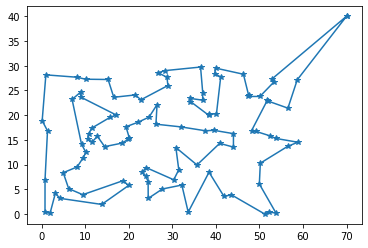

[[5.37121e+01 1.53046e+01 5.11758e+01 3.22000e-02 4.63253e+01 2.82753e+01
  3.03313e+01 6.93480e+00]
 [5.65432e+01 2.14188e+01 1.08198e+01 1.62529e+01 2.27891e+01 2.31045e+01
  1.01584e+01 1.24819e+01]
 [2.01050e+01 1.54562e+01 1.94510e+00 2.05700e-01 2.64951e+01 2.21221e+01
  3.14847e+01 8.96400e+00]
 [2.62418e+01 1.81760e+01 4.40356e+01 1.35401e+01 2.89836e+01 2.59879e+01
  3.84722e+01 2.01731e+01]
 [2.82694e+01 2.90011e+01 3.21910e+01 5.86990e+00 3.64863e+01 2.97284e+01
  9.71800e-01 2.81477e+01]
 [8.95860e+00 2.46635e+01 1.65618e+01 2.36143e+01 1.05597e+01 1.51178e+01
  5.02111e+01 1.02944e+01]
 [8.15190e+00 9.53250e+00 2.21075e+01 1.85569e+01 1.21500e-01 1.88726e+01
  4.82077e+01 1.68889e+01]
 [3.19499e+01 1.76309e+01 7.73200e-01 4.65600e-01 4.74134e+01 2.37783e+01
  4.18671e+01 3.56670e+00]
 [4.35474e+01 3.90610e+00 5.33524e+01 2.67256e+01 3.08165e+01 1.34595e+01
  2.77133e+01 5.07060e+00]
 [2.39222e+01 7.63060e+00 5.19612e+01 2.28511e+01 1.27938e+01 1.57307e+01
  4.95680e+00 8.3

In [4]:
# 旅行商问题
import numpy as np
from numpy import radians, arccos, cos, sin, exp
import matplotlib.pyplot as plt


a = np.loadtxt("Pdata17_1.txt") # 这样读入会自动按空格分割，生成ndarray

# with open("Pdata17_1.txt", 'r') as f: # 这样只会读入为字符串
#     a = f.read()

x = a[:, ::2].flatten()
y = a[:, 1::2].flatten()
d1 = np.array([70, 40]) # 起点
xy = np.vstack([d1, np.column_stack([x, y]), d1])
N = xy.shape[0] # N = 102
t = radians(xy) # 转化为弧度
d = np.array([[6370 * arccos(cos(t[i,0]-t[j,0])*cos(t[i,1])*cos(t[j,1]) + sin(t[i,1])*sin(t[j,1]))
               for j in range(N)] for i in range(N)]).real
# 生成邻接矩阵(对称矩阵)

"""
预处理: Monte Carlo方法: 先初步筛选, 给出一些可行的解
"""
path = np.arange(N) # 保存路径  0,1,...,101
L = np.inf # 保存最小值答案
for _ in range(1000): # 设定随机1000次操作(可以改成其他值)
    path0 = np.arange(1, N-1)
    np.random.shuffle(path0)
    path0 = np.hstack([0, path0, N-1]) # 打乱path中间的N-2项生成path0
    L0 = d[path[0], path0[1]]
    for i in range(1, N-1):
        L0 += d[path[i], path[i+1]] # 求总路程
    if L0 < L: # 更新
        path = path0
        L = L0
print(path, L, sep='\n')

"""
模拟退火法(关键在于'概率'的运用,以及退火的流程)
"""
e = 0.1**30 # 终止温度
M = 50000 # 循环次数上限
alpha = 0.999 # 降温系数
T = 1 # 起始温度
for _ in range(M):
    rnd = np.random.randint(1, 101, size=2)
    rnd.sort()
    u = rnd[0]
    v = rnd[1] # 生成1,2,...,100中的两个随机数, u < v
    df = (d[path[u-1], path[v]] + d[path[u], path[v+1]]
          - d[path[u-1], path[u]] - d[path[v], path[v+1]])
    if df < 0:
        path = np.hstack([path[:u], # 0,1,...,u-1
                          path[v:u-1:-1], # v,v-1,...,u+1,u
                          path[v+1:]]) #v+1,...,101
        L = L + df
    elif exp(-df/T) >= np.random.rand(1): # 0-1随机数
        path = np.hstack([path[:u],
                          path[v:u-1:-1],
                          path[v+1:]])
        L = L + df
    T = T * alpha # 退火
    if T < e: break # 温度小于终止温度则退出,否则继续
print(path, L, sep='\n') # 输出巡航路径及路径长度


xx = xy[path, 0]
yy = xy[path, 1]
plt.plot(xx, yy, '-*')
plt.show()  #画巡航路径